In [14]:
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm


df1=pd.read_csv('./data/Shanghai Composite Historical Data.csv')
print(df1.columns)
df1=pd.DataFrame({
    'Data':df1.Date.values[::-1],
    'Price':[float(i.replace(',','')) for i in df1['Price'].values][::-1],
    'Open':[float(i.replace(',','')) for i in df1['Open'].values][::-1],
    'High':[float(i.replace(',','')) for i in df1['High'].values][::-1],
    'Low':[float(i.replace(',','')) for i in df1['Low'].values][::-1]
                  })
df1

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


,Data,Price,Open,High,Low
0,11/01/2022,2969.20,2899.50,2969.20,2896.76
1,11/02/2022,3003.37,2960.65,3019.05,2954.95
2,11/03/2022,2997.81,2981.20,3003.72,2977.72
3,11/04/2022,3070.80,2997.00,3081.59,2997.00
4,11/07/2022,3077.82,3062.86,3088.19,3054.46
...,...,...,...,...,...
242,10/31/2023,3018.77,3019.65,3023.00,3006.61
243,11/01/2023,3023.08,3038.18,3038.33,3013.93
244,11/02/2023,3009.41,3028.66,3038.64,3009.12
245,11/03/2023,3030.80,3012.47,3040.98,3012.47


In [15]:
#Params
time_window = 14
pred_window=7

BATCH_SIZE=16
nums_layer=1
lr=5e-4
test_size=0.2
N_epoch=100
device = torch.device('mps')

feature_count=4
Price_data2=df1[['Price', 'Open', 'High', 'Low']].values

scaler1=MinMaxScaler()
Price_data=scaler1.fit_transform(Price_data2)
print(Price_data.shape)

data_his=[]
data_pred=[]
for i in range(len(Price_data)-time_window-pred_window):
    data_his.append(np.array(Price_data[i:i+time_window,]))
    data_pred.append(np.array(Price_data[i+time_window:i+time_window+pred_window,]))

print(data_his[0],data_pred[0])
print(len(data_his),len(data_pred))

(247, 4)
[[0.06563385 0.         0.00977564 0.        ]
 [0.14061574 0.12159717 0.11953147 0.12147718]
 [0.128415   0.16246098 0.08577908 0.16901173]
 [0.28858265 0.19387938 0.25722715 0.20926057]
 [0.30398718 0.32484241 0.27175852 0.32921381]
 [0.27473613 0.35357633 0.24993945 0.31460064]
 [0.23892388 0.32802402 0.24033995 0.3119494 ]
 [0.21250357 0.26286067 0.18322728 0.26322492]
 [0.32476794 0.39799956 0.33681939 0.36228132]
 [0.31623181 0.40042554 0.34489971 0.37255229]
 [0.42744289 0.36119231 0.37612013 0.37104923]
 [0.39650216 0.46560878 0.39848962 0.4563275 ]
 [0.38651774 0.42048957 0.33175543 0.39749906]
 [0.34660201 0.43196325 0.35656884 0.41779049]] [[0.31983059 0.35506771 0.26526344 0.3327836 ]
 [0.32838867 0.36733679 0.33765605 0.37484865]
 [0.34587786 0.36835093 0.31590304 0.37276105]
 [0.32920059 0.40684842 0.32691164 0.39267671]
 [0.35636699 0.36978266 0.32290451 0.37829318]
 [0.30558908 0.30978942 0.25412272 0.28796292]
 [0.46182879 0.39096025 0.41225038 0.41616216]]
22

In [16]:
data_his=np.array(data_his)
data_pred=np.array(data_pred)

print(data_his.shape,data_pred.shape)

Train_x,Train_y=data_his[:-int(test_size*len(data_his))],data_pred[:-int(test_size*len(data_his))]
Test_x,Test_y=data_his[-int(test_size*len(data_his)):],data_pred[-int(test_size*len(data_his)):]
print(Train_x.shape,Train_y.shape,Test_x.shape,Test_y.shape)

class TimeDataset(Dataset):
    def __init__(self,df_x,df_y):
        self.data=df_x
        self.label=df_y
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        data_value=torch.FloatTensor(self.data[index,:])
        label_value=torch.FloatTensor([self.label[index]])
        return data_value,label_value.view(pred_window,feature_count)

train_dataset=TimeDataset(df_x=Train_x,df_y=Train_y)
valid_dataset=TimeDataset(df_x=Test_x,df_y=Test_y)
train_iterator=DataLoader(train_dataset,batch_size=BATCH_SIZE)
valid_iterator=DataLoader(valid_dataset,batch_size=BATCH_SIZE)
#test
for (data,label) in train_iterator:
    print(data.shape)
    print(label.shape)
    break


(226, 14, 4) (226, 7, 4)
(181, 14, 4) (181, 7, 4) (45, 14, 4) (45, 7, 4)
torch.Size([16, 14, 4])
torch.Size([16, 7, 4])


In [17]:
class FCN(nn.Module):
    def __init__(self,InputDim=time_window*feature_count,OutputDim=pred_window*feature_count,nums_layer=6):
        super().__init__()
        layers=[]
        for i in range(nums_layer):
            layers+=[nn.Linear(4096,4096),
                     nn.LeakyReLU(),
                     nn.Linear(4096,4096)
                     ]
        self.layer1=nn.Sequential(
            nn.Linear(InputDim, 4096),
            nn.LeakyReLU(),
        )
        self.layer2=nn.Sequential(*layers)
        self.layer3=nn.Sequential(
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(4096,64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32,out_features=OutputDim),

        )

    def forward(self,data):
        x=self.layer1(data)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

def train(model, iterator, optimizer, criterion,device='cpu'):
    epoch_loss = 0
    model=model.to(device)
    model.train()
    for batch in iterator:
        batch[0]=batch[0].reshape(batch[0].shape[0],-1).to(device)
        batch[1]=batch[1].reshape(batch[1].shape[0],-1).to(device)
        criterion=criterion.to(device)
        optimizer.zero_grad()
        predictions = model(batch[0])

        loss = criterion(predictions, batch[1])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator,criterion,device='cpu'):
    epoch_loss = 0
    model=model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            batch[0]=batch[0].reshape(batch[0].shape[0],-1).to(device)
            batch[1]=batch[1].reshape(batch[1].shape[0],-1).to(device)
            criterion=criterion.to(device)
            predictions = model(batch[0])
            loss = criterion(predictions, batch[1])
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

lossfunction=nn.MSELoss()
fc_model=FCN(nums_layer=nums_layer)
# fc_model=FullyConnectedModel()
optimizer=torch.optim.Adam(fc_model.parameters(),lr=lr)


In [18]:
train_loss_list=[]
valid_loss_list=[]

par=tqdm(range(N_epoch))

for i in par:
    train_loss=train(model=fc_model,iterator=train_iterator,criterion=lossfunction,optimizer=optimizer,device=device)
    valid_loss=evaluate(model=fc_model,iterator=valid_iterator,criterion=lossfunction,device=device)
    # print("Epoch:{}".format(i+1))
    # print("Training Loss:{:.4f}".format(train_loss),"Valid Loss:{:.4f}".format(valid_loss))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    if i ==0:
        best_valid_loss=valid_loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # print('Save Model..')
        par.set_description_str("Epoch:{}".format(i+1)+' Save!')
        torch.save(fc_model.state_dict(), './result/fc_model.pt')
    else:
        par.set_description_str("Epoch:{}".format(i+1))

    par.set_postfix_str("Training Loss:{:.4f}".format(train_loss)+" Valid Loss:{:.4f}".format(valid_loss))


Epoch:100: 100%|██████████| 100/100 [00:29<00:00,  3.35it/s, Training Loss:0.0155 Valid Loss:0.0255]    


In [19]:
fc_model.load_state_dict(torch.load('./result/fc_model.pt',map_location='cpu'))
fc_model.to('cpu')
train_iterator=DataLoader(train_dataset,batch_size=1)
valid_iterator=DataLoader(valid_dataset,batch_size=1)
list1=[]
list2=[]
real_y_1=[]
real_y_2=[]

with torch.no_grad():
    for batch in train_iterator:
        data=batch[0].reshape(batch[0].shape[0],-1).to('cpu')
        pre1=fc_model(data)[0][0]
        list1.append(pre1)
        real_y_1.append(batch[1].to('cpu')[0][0][0])

    for batch in valid_iterator:
         data=batch[0].reshape(batch[0].shape[0],-1).to('cpu')
         pre2=fc_model(data)[0][0]
         list2.append(pre2)
         real_y_2.append(batch[1].to('cpu')[0][0][0])

list2=np.array([i.detach().numpy() for i in list2]).reshape(-1)
list1=np.array([i.detach().numpy() for i in list1]).reshape(-1)
real_y_1=np.array([i.detach().numpy() for i in real_y_1]).reshape(-1)
real_y_2=np.array([i.detach().numpy() for i in real_y_2]).reshape(-1)

In [20]:
print(len(list1),len(list2),len(real_y_1),len(real_y_2))


181 45 181 45


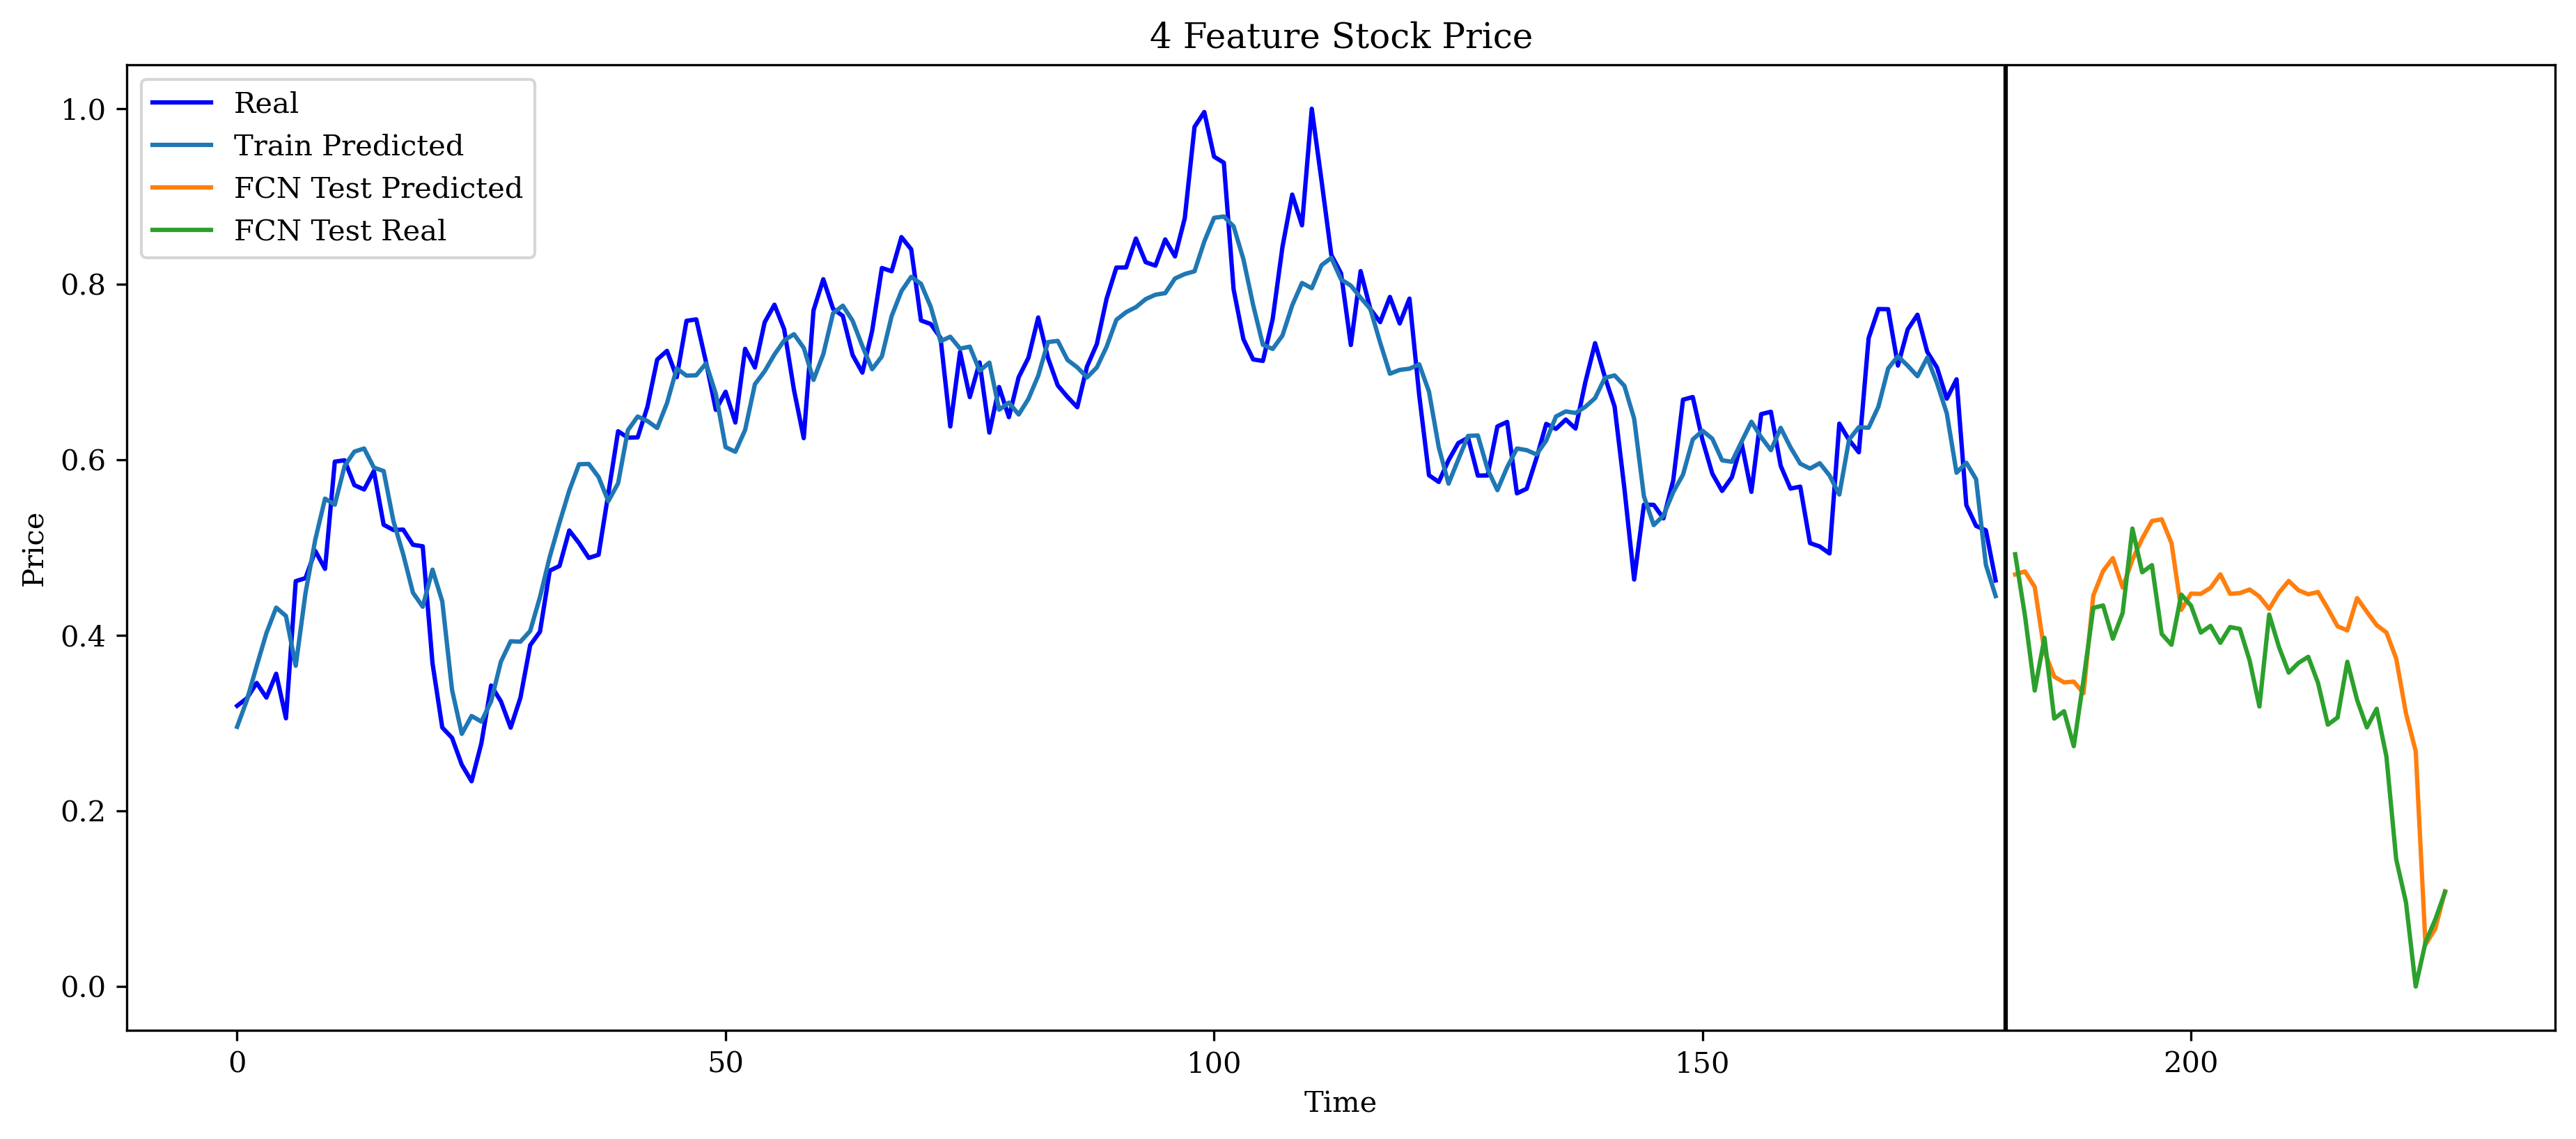

In [21]:
plt.rcParams['font.family']='serif'
plt.figure(figsize=(15,6),dpi=300)
plt.title('4 Feature Stock Price')
plt.plot(range(len(real_y_1)),real_y_1,color='blue',label='Real')
plt.plot(range(len(list1)),list1,label='Train Predicted')
plt.plot(range(len(real_y_1)+1,len(real_y_1)+len(list2)+1),list2,label='FCN Test Predicted')
plt.plot(range(len(real_y_1)+1,len(real_y_1)+len(list2)+1),real_y_2,label='FCN Test Real')
# plt.plot(range(len(Y_train_p)+1,len(Y_train_p)+len(Yvalidation)+1),Yvalidation)
# plt.plot(validation.index,pd.DataFrame(LSTM_pred),color='red',label='LSTM Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.axvline(len(real_y_1),color='black')
plt.legend(loc = "upper left")
plt.savefig('./result/4 Feature Prediction.jpg')